# Importing Libraries

In [56]:
from utils import *
from sklearn.manifold import TSNE
from datetime import datetime
import time
import math
%matplotlib inline

In [57]:
#pretty plot
#sns.set_style("darkgrid")
a4_dims = (11.7,11.7)
sns.set_context("paper", font_scale = 1.5, rc={"lines.linewidth":2.5})

In [58]:
MAX_LENGTH = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Reading the Data In
We are using the Air Travel Information System (ATIS) dataset(I believe it is originally from UPenn, need to verify)
It uses the Inside-Out-Beginning tag format(IOB) described here : https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)

The typical structure is:

Sentence (tokens), Slots to match each token, Intent.

Found a preprocessed atis file from, thanks to: https://github.com/D2KLab/botcycle/tree/master/nlu/data/atis


In [59]:
with open('data/preprocessed/fold_train.json', 'r') as f:
    atis_json = json.load(f)

In [60]:
#atis_json['data'][3130] #total 4978
top_5_intents_idxs = {'atis_flight':[],
                      'atis_airfare':[],
                      'atis_ground_service':[],
                      'atis_airline':[],
                      'atis_abbreviation':[]}

In [61]:
#atis_json['data'][0]
for i in range(len(atis_json['data'])):
    loop_intent = atis_json['data'][i]['intent']
    if loop_intent in top_5_intents_idxs.keys():
        top_5_intents_idxs[loop_intent].append(i)

In [62]:
atis_json['data'][31]
#top_5_intents_idxs['atis_abbreviation']

{'words': ['what', 'does', 'fare', 'code', 'y', 'mean'],
 'slots': ['O', 'O', 'O', 'O', 'B-fare_basis_code', 'O'],
 'length': 6,
 'intent': 'atis_abbreviation'}

# Exploratory Data Analysis of training set

In [6]:
word_counts = {}
slot_counts = {}
intent_counts = {}
max_len_w_idx = [(0,atis_json['data'][0]['length'])]
num_tokens = 0
idx = 0
for atis_entry in atis_json['data']:
    num_tokens+=atis_entry['length']
    if atis_entry['length'] > max_len_w_idx[0][1]:
        max_len_w_idx[0] = (idx,atis_entry['length'])
    if atis_entry['intent'] not in intent_counts.keys():
            intent_counts[atis_entry['intent']] = 1
    else:
        intent_counts[atis_entry['intent']]+= 1
    for slot in atis_entry['slots']:
        if slot not in slot_counts.keys():
            slot_counts[slot] = 1
        else:
            slot_counts[slot]+= 1
    for word in atis_entry['words']:
        if word not in word_counts.keys():
            word_counts[word] = 1
        else:
            word_counts[word]+= 1
    idx+=1
    
slot_counts
intent_counts
max_len_w_idx

[(3130, 46)]

In [ ]:
intent_counts

In [ ]:
word_stats_df = pd.DataFrame(word_counts,index=[0])
word_stats_df.T.head()
word_stats_df.T.columns
word_stats_df.T.loc[word_stats_df.T[0].idxmax()]

In [ ]:
word_stats_df.T.head()

In [ ]:
# top 5 tokens
word_stats_df.T.sort_values(0,ascending=False).head()

## Distribution of Slots 

In [9]:
# 3919/40514 with O slot
# 3919/8759 without O slot
slot_stats_df = pd.DataFrame(slot_counts,index=[0])
labels = ['O'] #this is useless and many exist in all queries need not include.
slot_stats_df = slot_stats_df.drop(['O'],axis=1)
num_non_null_slots = np.sum(slot_stats_df.T.head())[0]
num_non_null_slots

8759

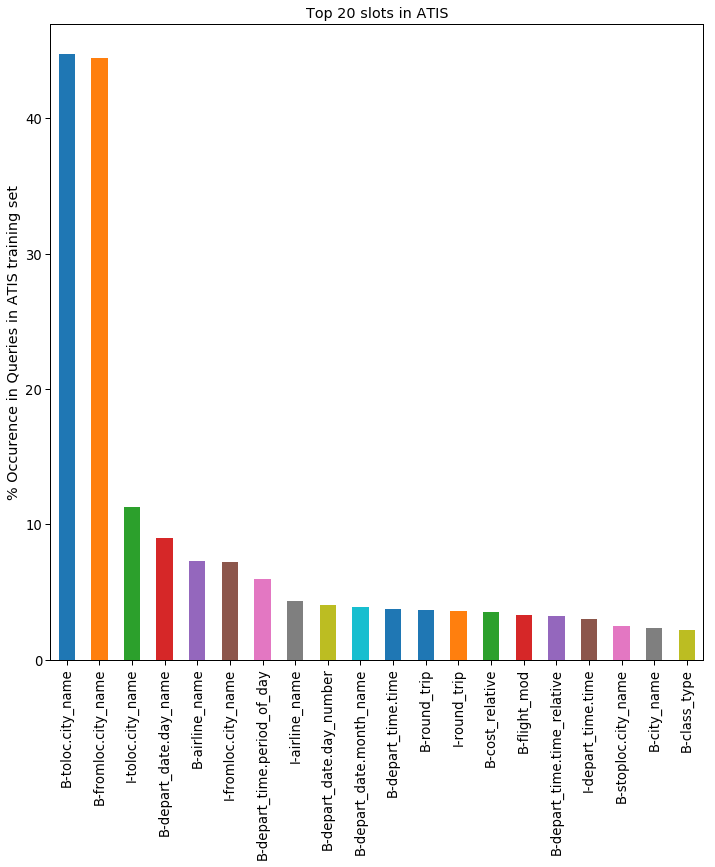

In [12]:
#https://stackoverflow.com/questions/31029560/plotting-categorical-data-with-pandas-and-matplotlib
#new_dims = (23,15)
fig, ax = plt.subplots()
bar_form_slots = slot_stats_df.T[0].sort_values(0,ascending=False)#sorted
bar_form_slots = (bar_form_slots/num_non_null_slots)*100 #as percentage
#print(type(bar_form_slots))
bar_form_slots[:20].plot(kind='bar',legend=False,figsize=a4_dims)
fig = ax.get_figure()
plt.title('Top 20 slots in ATIS')
plt.ylabel('% Occurence in Queries in ATIS training set')
fig.savefig("graphs/slot_dist_20.png",bbox_inches="tight",dpi=300)

## Distribution of Intents

In [17]:
intent_stats_df = pd.DataFrame(intent_counts,index=[0])
intent_stats_df.columns = intent_stats_df.columns.str.replace("atis_",'')
intent_stats_df = intent_stats_df.T.sort_values(0,ascending=False)#sorted

total_num_intent = 4478
intent_stats_df = (intent_stats_df/total_num_intent)*100

#intent_stats_df.iloc[:,0]

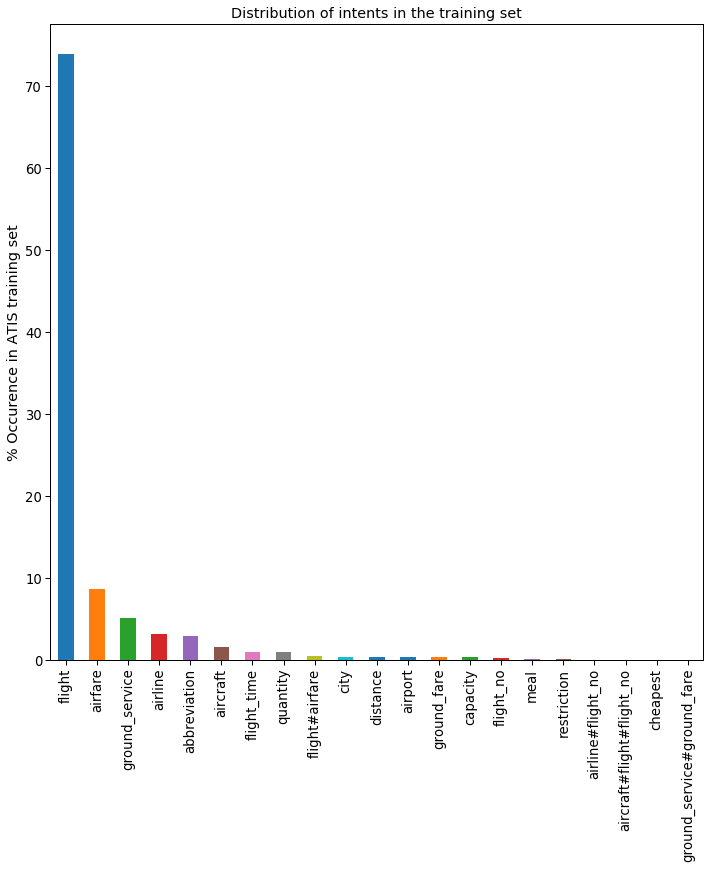

In [19]:
fig, ax = plt.subplots()
intent_stats_df.iloc[:,0].plot(kind='bar',legend=False,figsize=a4_dims)
fig = ax.get_figure()
plt.title('Distribution of intents in the training set')
plt.ylabel('% Occurence in ATIS training set')
fig.savefig("graphs/intent_dist_clean_label.png",bbox_inches="tight",dpi=300)

# Data Preprocessing

In [63]:
def flatten(list_of_lists):
    """Flattens from two-dimensional list to one-dimensional list"""
    return [item for sublist in list_of_lists for item in sublist]

In [64]:
def adjust_sequences(data, length=MAX_LENGTH):
    """
    Fixes the input and output sequences length, adding padding or truncating if necessary
    :param data json file containing entries from atis dataset.
    :param length the fixed length of the sentence.
    """
    for sample in data['data']:
        # adjust the sequence of input words
        if len(sample['words']) < length:
            # add <EOS> and <PAD> if sentence is shorter than maximum length
            sample['words'].append('<EOS>')
            while len(sample['words']) < length:
                sample['words'].append('<PAD>')
        else:
            # otherwise truncate and add <EOS> at last position
            sample['words'] = sample['words'][:length]
            sample['words'][-1] = '<EOS>'

        # adjust in the same way the sequence of output slots
        if len(sample['slots']) < length:
            sample['slots'].append('<EOS>')
            while len(sample['slots']) < length:
                sample['slots'].append('<PAD>')
        else:
            sample['slots'] = sample['slots'][:length]
            sample['slots'][-1] = '<EOS>'

    return data

In [65]:
def get_vocabularies(train_data):
    """
    Collect the input vocabulary, the slot vocabulary and the intent vocabulary
    :param train_data the training data containing words,slots and intent.
    """
    # from a list of training examples, get three lists (columns)
    data = train_data['data']
    seq_in = [sample['words'] for sample in data]
    vocab = flatten(seq_in)
    # removing duplicated but keeping the order
    v = ['<PAD>', '<SOS>', '<EOS>'] + vocab
    vocab = sorted(set(v), key=lambda x: v.index(x)) # https://docs.python.org/3.3/howto/sorting.html
    s = ['<PAD>', '<SOS>', '<EOS>'] + train_data['meta']['slot_types']
    slot_tag = sorted(set(s), key=lambda x: s.index(x))
    i = train_data['meta']['intent_types']
    intent_tag = sorted(set(i), key=lambda x: i.index(x))

    return vocab, slot_tag, intent_tag

In [66]:
adjusted_atis = adjust_sequences(atis_json)#padded

In [67]:
atis_vocab,atis_slots,atis_intents = get_vocabularies(adjusted_atis)

In [68]:
#atis_intents
#atis_vocab

In [69]:
len(atis_vocab),len(atis_slots),len(atis_intents)

(870, 123, 21)

# Next we need to embed the data and set it up for Pytorch
Remember each vocabulary for each sentence, slot and intent will have different embeddings. They are different sized vectors. The Network will try to figure out a mapping from these different vector spaces.

In [70]:
def create_mappings(vocab,forward_map):
    """
    This function takes the words in the vocabulary and creates a unique mapping to a number.
    :param vocab contains all the words in the corpus.
    :param forward_map a dictionary that will be populated with mappings.
    returns populated forward_map
    """
    for sample in vocab:
        if sample not in forward_map.keys():
            forward_map[sample]= len(forward_map)
            
    return forward_map

In [71]:
# SOS_token = 2
# EOS_token = 3
word2index = {'<PAD>': 0, '<UNK>':1,'<SOS>':2,'<EOS>':3}
create_mappings(atis_vocab,word2index)
index2word = {v:k for k,v in word2index.items()}

In [72]:
tag2index = {'<PAD>' : 0,'<UNK>':1,'<SOS>':2,'<EOS>':3}
create_mappings(atis_slots,tag2index)
index2tag = {v:k for k,v in tag2index.items()}

In [73]:
intent2index={}
create_mappings(atis_intents,intent2index)
index2intent = {v:k for k,v in intent2index.items()}

In [382]:
#tag2index
#word2index
index2intent

{0: 'atis_abbreviation',
 1: 'atis_aircraft',
 2: 'atis_aircraft#atis_flight#atis_flight_no',
 3: 'atis_airfare',
 4: 'atis_airline',
 5: 'atis_airline#atis_flight_no',
 6: 'atis_airport',
 7: 'atis_capacity',
 8: 'atis_cheapest',
 9: 'atis_city',
 10: 'atis_distance',
 11: 'atis_flight',
 12: 'atis_flight#atis_airfare',
 13: 'atis_flight_no',
 14: 'atis_flight_time',
 15: 'atis_ground_fare',
 16: 'atis_ground_service',
 17: 'atis_ground_service#atis_ground_fare',
 18: 'atis_meal',
 19: 'atis_quantity',
 20: 'atis_restriction'}

### Next we create a Tensor where each row is a mapped/embedded sequence

In [74]:
def prepare_sequence(seq_data, mapping,map_type):
    """
    :param seq a sequnce which will be embedded as a vector
    :param mapping, a dictionary which contains how each element in the seq will be mapped to a number.
    :param map_type 'words','slots' or 'intent'
    returns a Pytorch Tensor.
    """
    if map_type=='intent':
        intent = seq_data[map_type]
        embeddings = mapping[intent] if intent in mapping.keys() else -1 #mapping["<UNK>"]
        return torch.tensor(embeddings)   
    else:
        embed_fnc = lambda word: mapping[word] if word in mapping.keys() else mapping["<UNK>"]
        embeddings = list(map(embed_fnc, seq_data[map_type])) 
        return torch.LongTensor(embeddings)

In [75]:
def create_training_set(padded_atis):
    """
    :param padded_atis, this is padded sequence data.
           Of the form seq,slots,intent. This function coverts 
           these into tensors.
    return train_data; [(seq_tensor,slot_tensor,intent_tensor)]
    """
    train_data = []
    atis_data = padded_atis['data']
    for i in range(len(atis_data)):
        seq_tensor = prepare_sequence(atis_data[i],word2index,'words')
        slot_tensor = prepare_sequence(atis_data[i],tag2index,'slots')
        intent_tensor = prepare_sequence(atis_data[i],intent2index,'intent')
        train_data.append((seq_tensor,slot_tensor,intent_tensor))
    return train_data

In [76]:
train_data = create_training_set(adjusted_atis)

# Batching the data

In [77]:
def concatenate_batch(batch):
#     print(len(batch), len(batch[0]))
    #     print([ex[0] for ex in batch])
    seqs = torch.stack([ex[0] for ex in batch])
    slots = torch.stack([ex[1] for ex in batch])
    intents = torch.stack([ex[2] for ex in batch])
   
    return seqs,slots,intents

In [78]:
def get_batches(batch_size, train_data):
    """
    Returns iteratively a batch of specified size on the data. 
    The last batch can be smaller if the total size is not multiple of the batch
    """
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while sindex < len(train_data):
        batch = train_data[sindex:eindex] #list of batch_size num of tuples.
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        #print('returning', len(batch), 'samples')
        yield concatenate_batch(batch)

In [ ]:
# batches = get_batches(5,train_data[:10])
# list(batches)[0][0].size()

# Building Joint -RNNless Model

In [368]:
class Encoder(nn.Module):
    """
    An encoder/decoder that
    takes a batch of sequences embeds the sequence and
    then runs it through a fully connected layer to predict slots and intent.
    """
    def __init__(self,input_dim,slot_dim,intent_dim,emb_dim):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.slot_dim = slot_dim
        self.intent_dim = intent_dim
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.slot_fc = nn.Linear(emb_dim,slot_dim)
        self.intent_fc = nn.Linear(emb_dim,intent_dim)
        
    def forward(self,src):
        embedded = self.embedding(src)# get embedding for a word
        #print(embedded.size())
        slots = self.slot_fc(embedded)# then predict a slot using fc
        
        # Need average embedding for a sequence
        avg_embedding = embedded.mean(dim=1) #[50,5]-> [5] because don't have 50 different elements anymore just one.
        #print('embed',embedded.size())
        #print('avg embed:',avg_embedding.size())
        intent = self.intent_fc(avg_embedding)
        #print('intent pred',intent.size())
        # then put average embedding into intent fc
        
        return slots,intent,embedded,avg_embedding

In [ ]:
print("Testing models...")
n_layers = 1
INPUT_DIM = len(word2index)
SLOT_DIM = len(tag2index)
print('Inp: ',INPUT_DIM,'Slotdim: ',SLOT_DIM)
INTENT_DIM = len(index2intent)
embed_size = 5
inp = get_batches(1,train_data[:1])
encoder = Encoder(INPUT_DIM,SLOT_DIM,INTENT_DIM,embed_size)
# testing avg embedding
for data in inp:
    input,label,real_intent = data[0],data[1],data[2]#.type(torch.FloatTensor)
    slot,intent,_,_ = encoder(input)
    print(_.size())
    slot = torch.argmax(slot,dim=2)
    test_criterion = nn.CrossEntropyLoss()
#     print(real_intent.size(),intent.size())
#     print('real intent',real_intent,'predicted intent',intent)
    test_criterion(intent,real_intent)
    #intent = torch.argmax(intent,dim=1).type(torch.FloatTensor)
    #print(slot.size())
    #print(intent.size())
#batches = get_batches(5,train_data[:10]) # to get each representation of a word.

In [ ]:
#list(encoder.parameters())

In [ ]:
test_criterion = nn.CrossEntropyLoss()
real_intent,intent
test_criterion(intent,real_intent)

# Training the model & Running Experiments
Here we vary the embedding size in the embedding layer while keeping the learning rate, batch_size, optimizer 
and other network parameters constant.

In [ ]:
def train_model(model,num_epochs,batch_size,optimizer,train_data,constant_params):
    loss_by_epoch = {}
    criterion = constant_params['criterion']
    model.train()
    for epoch in range(num_epochs):
        slot_losses = []
        intent_losses = []
        inp = get_batches(batch_size,train_data)
        for data in inp:
            inputs, labels, intents = data[0],data[1],data[2]
            inputs = inputs.type(torch.LongTensor).to(device)
            labels = labels.type(torch.LongTensor).view(-1).to(device) #squashing
            intents = intents.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            out_slots, out_intents,_ = model(inputs)
            out_slots = out_slots.view(-1,constant_params['SLOT_DIM'])

            slot_loss = criterion(out_slots, labels)
            intent_loss = criterion(out_intents, intents) 
            slot_losses.append(slot_loss.item())
            intent_losses.append(intent_loss.item())
            
            slot_loss.backward(retain_graph=True)
            intent_loss.backward()
            optimizer.step()
        slot_col_name = "epoch:"+str(epoch+1)+"_slot_losses"
        intent_col_name = "epoch:"+str(epoch+1)+"_intent_losses"
        loss_by_epoch[slot_col_name] = slot_losses
        loss_by_epoch[intent_col_name] = intent_losses
        
    return loss_by_epoch #slot_losses, intent_losses,

def make_models(constant_params,vary_params):
    #make a model with a different embedding size
    model_list = []
    for i in range(len(vary_params['embed_size'])):
        model_list.append( Encoder(constant_params['INPUT_DIM'],
                                      constant_params['SLOT_DIM'],
                                      constant_params['INTENT_DIM'],
                                      vary_params['embed_size'][i]).to(device) )
    return model_list

def run_experiment(constant_params,vary_params,num_runs,exp_data,model_type='ann'):
    experiment_results = {}
    list_of_dfs = []
    for run in range(num_runs): # fill dict with keys
        for i in range(len(vary_params['embed_size'])):
            col_name = 'run_'+str(run+1)+'_embed_size_'+str(vary_params['embed_size'][i])
            experiment_results[col_name] = []
           
    for run in range(num_runs):# run actual experiments
        run_model_list = make_models(constant_params,vary_params)
        for i in range(len(run_model_list)):
            optimizer = optim.Adam(run_model_list[i].parameters(), lr=0.01)
            col_name = 'run_'+str(run+1)+'_embed_size_'+str(vary_params['embed_size'][i])
           
            loss_by_epoch = train_model(run_model_list[i],
                                                    constant_params['num_epoch'],
                                                   constant_params['batch_size'],
                                                   optimizer,
                                                   exp_data,
                                                   constant_params)
            
            result_dataframe = pd.DataFrame(loss_by_epoch,index=None)
            result_dataframe.to_csv("experiment_results/"+
                                    str(model_type)+
                                    str(run)+"_"+
                                    str(vary_params['embed_size'][i])+"_"
                                    "train_experiment.csv")
            list_of_dfs.append(result_dataframe)
            #experiment_results[col_name].append(loss_by_epoch)
            #experiment_results[col_name].append(run_intent_losses)
                
    # after experiments are over save as a .csv
#     result_dataframe = pd.DataFrame(experiment_results,index=None)
#     result_dataframe.to_csv("experiment_results/"+str(model_type)+"train_experiments.csv")
    return list_of_dfs #incase we want it

In [ ]:
constant_exp_params = {'batch_size':128,
                       'num_epoch':200,
                      'INPUT_DIM':len(word2index),
                      'SLOT_DIM':len(tag2index),
                      'INTENT_DIM':len(index2intent),
                      'criterion': nn.CrossEntropyLoss(ignore_index=0,reduction='elementwise_mean')}

variable_exp_params = {'embed_size':[2,4,8,16,32,64,128,256]}
                        

In [ ]:
start = time.time()
run_experiment(constant_exp_params,variable_exp_params,5,train_data,model_type='ann')
end = time.time()
elapsed = (end-start)/60.
print('Time elapsed: %.4f mins ' % (elapsed))

# =================== #

In [369]:
batch_size = 128
max_length = 50
INPUT_DIM = len(word2index)#
SLOT_DIM = len(tag2index)
INTENT_DIM = len(index2intent)
embed_size = 256 
num_epochs = 200

In [370]:
encoder = Encoder(INPUT_DIM,SLOT_DIM,INTENT_DIM,embed_size).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0,reduction='elementwise_mean')#ignore <pad>
optimizer = optim.Adam(encoder.parameters(), lr=0.01)

In [ ]:
encoder

In [ ]:
# len(atis_intents)
# len(atis_slots)
# atis_slots
# tag2index

In [371]:
start = time.time()
for epoch in range(num_epochs):
    inp = get_batches(batch_size,train_data)
    encoder.train()
    for data in inp:
        # get the inputs
        inputs, labels, intents = data[0],data[1],data[2]
        inputs = inputs.type(torch.LongTensor).to(device)
        labels = labels.type(torch.LongTensor).view(-1).to(device) #squashing
        intents = intents.to(device)#.type(torch.FloatTensor)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        out_slots, out_intents,_,_ = encoder(inputs)
        out_slots = out_slots.view(-1,SLOT_DIM)
        
        slot_loss = criterion(out_slots, labels)
        intent_loss = criterion(out_intents, intents) 
        
        slot_loss.backward(retain_graph=True)
        intent_loss.backward()
        optimizer.step()
    if epoch%25==0:
        print('Slot Loss after epoch '+str(epoch)+':',slot_loss.item())
        print('Intent Loss after epoch '+str(epoch)+':',intent_loss.item())
        print('-----------------------------------------------')
end = time.time()
elapsed = (end-start)/60.
print('Time elapsed: %.4f mins ' % (elapsed))

Slot Loss after epoch 0: 0.3725486695766449
Intent Loss after epoch 0: 1.0433307886123657
-----------------------------------------------
Slot Loss after epoch 25: 0.31469783186912537
Intent Loss after epoch 25: 0.01830376125872135
-----------------------------------------------
Slot Loss after epoch 50: 0.2915521562099457
Intent Loss after epoch 50: 0.007380899507552385
-----------------------------------------------
Slot Loss after epoch 75: 0.2570587992668152
Intent Loss after epoch 75: 0.0028407834470272064
-----------------------------------------------
Slot Loss after epoch 100: 0.24385114014148712
Intent Loss after epoch 100: 0.0007999751251190901
-----------------------------------------------
Slot Loss after epoch 125: 0.26801013946533203
Intent Loss after epoch 125: 0.0012734320480376482
-----------------------------------------------
Slot Loss after epoch 150: 0.26211467385292053
Intent Loss after epoch 150: 0.006967470515519381
----------------------------------------------

## Evaluation of Encoder
 

In [83]:
with open('data/preprocessed/fold_test.json', 'r') as f:
    atis_test_json = json.load(f)

In [84]:
len(atis_test_json['data'])

500

In [85]:
#atis_test_json['data'][0]

In [86]:
adjusted_atis_test = adjust_sequences(atis_test_json)#padded

In [87]:
test_vocab,test_slots,test_intents = get_vocabularies(adjusted_atis_test)
#test_intents,index2intent

In [388]:
test_intents, intent2index

(['atis_abbreviation',
  'atis_aircraft',
  'atis_airfare',
  'atis_airfare#atis_flight_time',
  'atis_airline',
  'atis_airport',
  'atis_capacity',
  'atis_city',
  'atis_distance',
  'atis_flight',
  'atis_flight#atis_airfare',
  'atis_flight_time',
  'atis_ground_fare',
  'atis_ground_service',
  'atis_quantity',
  'atis_restriction'],
 {'atis_abbreviation': 0,
  'atis_aircraft': 1,
  'atis_aircraft#atis_flight#atis_flight_no': 2,
  'atis_airfare': 3,
  'atis_airline': 4,
  'atis_airline#atis_flight_no': 5,
  'atis_airport': 6,
  'atis_capacity': 7,
  'atis_cheapest': 8,
  'atis_city': 9,
  'atis_distance': 10,
  'atis_flight': 11,
  'atis_flight#atis_airfare': 12,
  'atis_flight_no': 13,
  'atis_flight_time': 14,
  'atis_ground_fare': 15,
  'atis_ground_service': 16,
  'atis_ground_service#atis_ground_fare': 17,
  'atis_meal': 18,
  'atis_quantity': 19,
  'atis_restriction': 20})

In [88]:
test_data = create_training_set(adjusted_atis_test) # should we cr

In [ ]:
len(test_data)#[0][1]

In [435]:
#Exclude pad 
def calc_bat_fscores(y_pred,y_true,predict_type='slot'):
    """
    Calc average f score for a batch.
    compares each predicted output in a batch to actual output.
    Then averages that.
    """
    batch_avg_f = []
    keep_slots = [i for i in tag2index.values() if (i > 3 and i!=123)]
    if predict_type=='slot':
        for pred_i in range(len(y_pred)):# range batch size
            #print(y_pred[pred_i].size())
            f_score = f1_score(y_true[pred_i], y_pred[pred_i],labels=keep_slots, average ='micro')  
            batch_avg_f.append(f_score)
    else:
        return f1_score(y_true,y_pred,average ='micro')
    return np.mean(batch_avg_f)

In [374]:
import warnings
warnings.filterwarnings('ignore')# get a lot of warnings because some labels are not predicted...

In [436]:
inp = get_batches(256,test_data)
encoder.eval()
f_slot_scores = []
f_intent_scores = []
for data in inp:
    # get the inputs
    inputs, labels , true_intents = data[0],data[1],data[2]
    inputs = inputs.type(torch.LongTensor).to(device)
    labels = labels.to(device)
    true_intents = true_intents.to(device)
    
#     if USE_CUDA and torch.cuda.is_available():
#         inputs = inputs.cuda()
#         labels = labels.cuda()
    
    slots ,intents, slot_embedding, avg_slot_embedding = encoder(inputs)
    y_pred_slots = torch.argmax(slots,dim=2)
    f_slot_scores.append(calc_bat_fscores(y_pred_slots,labels))
    y_pred_intents = torch.argmax(intents,dim=1)
    #print(y_pred_intents)
    #print(true_intents)
    #print(list(zip(true_intents.tolist(), y_pred_intents.tolist())))
    f_intent_scores.append(calc_bat_fscores(y_pred_intents,true_intents,predict_type='intent'))
print('Mean Slot F Metric :',np.mean(f_slot_scores))
print('-----------------------------------------------')
print('Mean Intent F Metric :',np.mean(f_intent_scores))

Mean Slot F Metric : 0.11888311748728927
-----------------------------------------------
Mean Intent F Metric : 0.9283427254098361


In [ ]:
#  # Change line width
# plt.xlabel('Slot F1-Scores')
# sns.boxplot(y = f_slot_scores, linewidth=1,width=0.05)

# Confusion Matrix For Intents since there are much less 

In [89]:
def categoryFromOutput(output):
    category_i = output.item()
    return index2intent[category_i], category_i

In [90]:
for data in get_batches(1,test_data[0:1]):
    input,_,intent = data[0],data[1],data[2]
    input = input.to(device)
    #print(input.size())
    output,intent_pred,_,_ = encoder(input)
    predictions = torch.argmax(intent_pred,dim=1)[0]
    print(output.size())
    print(predictions)
    print(categoryFromOutput(predictions))


torch.Size([1, 50, 124])
tensor(11)
('atis_flight', 11)


In [91]:
all_categories = []
intent_labels = ['abbreviation','aircraft','aircraft#flight#flight_no',
                 'airfare','airline','airline#flight_no','airport','capacity',
                'cheapest','city','distance','flight','flight#airfare','flight_no','flight_time',
                 'ground_fare','ground_fare_service','ground_service#ground_fare','meal',
                'quantity','restriction']
#intent_labels = atis_intents
for category in intent2index.values():
    all_categories.append(category)
      
len(all_categories),len(intent_labels)

(21, 21)

In [ ]:
#intent_labels
#index2intent
#len(intent_labels)

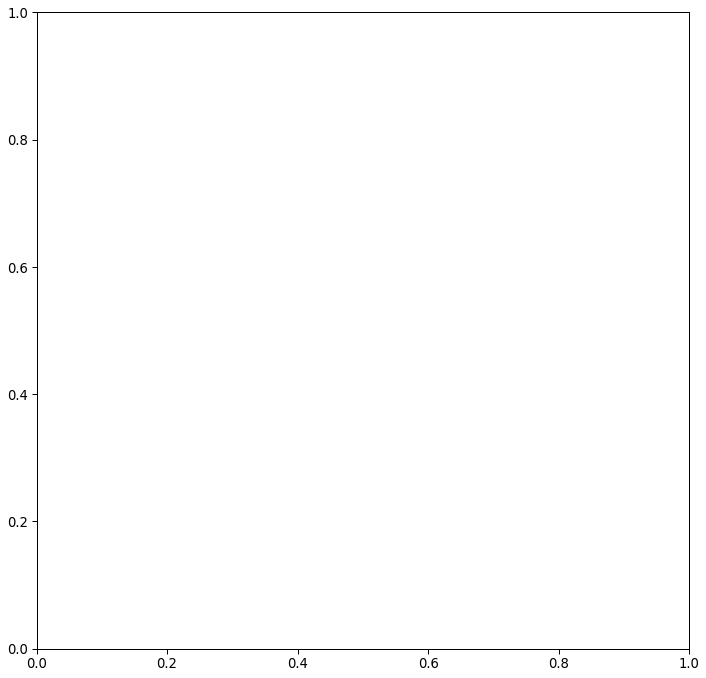

In [93]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('png','pdf')
new_dims = (15,15)
fig, ax = plt.subplots(figsize=a4_dims)

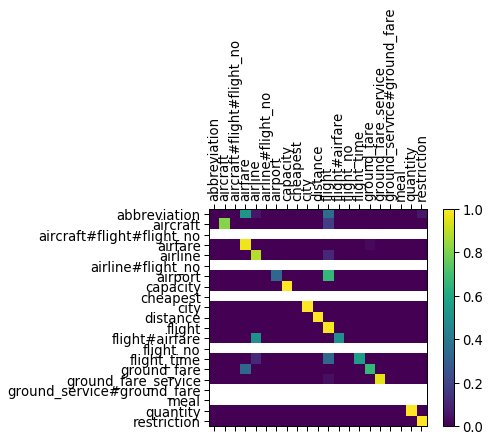

In [94]:
# Keep track of correct guesses in a confusion matrix
n_categories = len(all_categories)
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 5000

# Go through a bunch of examples and record which are correctly guessed
for data in get_batches(1,test_data):
    inputs, labels , true_intents = data[0],data[1],data[2]
    inputs = inputs.type(torch.LongTensor).to(device)
    labels = labels.to(device)
    true_intents = true_intents.to(device)
    output,intent_pred,_  = encoder(inputs)
    predictions = torch.argmax(intent_pred,dim=1)[0]
    #print(predictions, true_intents)
    guess, guess_i = categoryFromOutput(predictions)
    if true_intents.item()!= -1:#intent is in dataset
        category_i = all_categories.index(true_intents)
        confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + intent_labels, rotation=90)
ax.set_yticklabels([''] + intent_labels) #true

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()
fig = ax.get_figure()
fig.savefig("graphs/nn256_cm_with_intent",bbox_inches="tight",dpi=300)

# T-SNE
* Starting with 100 samples from the test set
* Then keeping track of the labels we pass the samples through our model to get an embedding: [batch size,50,5]
* With this embedding we try to drop remove the embeddings of 0 since they will appear often. 
* With the 0s removed, we apply T-SNE. 
* Plot the T-SNE embedding.

# Would a t-SNE visualization be useful?
Filter out top ten popular classes in testing set.
Then randomly sample slot emebddings from those.
Do the t-SNE embedding.
Remember embeddings are in order, this helps to label.

Looking t-SNE to visualize the results? How do the intent predictions and querie predictions look.
Are the intents near the queries when visualized?

Put in embedding into t-SNE and hopefully observe spatial semantic labels

output should be 870,2

color according to slot value and hopefully see color clusters

## COLOR BY INTENT


# t-SNE visualization of slot embeddings

In [376]:
data_used_eval = {'words':[],'labels':[],'intents':[],'embeddings':[],'avg_embeddings':[]}
inp = get_batches(10,test_data)
encoder.eval()
for data in inp:
    inputs, labels, true_intents = data[0],data[1],data[2]
    inputs = inputs.type(torch.LongTensor).to(device)
    slots, intents, slot_embedding, avg_slot_embedding = encoder(inputs)
    data_used_eval['words'].append(inputs)
    data_used_eval['labels'].append(labels)
    data_used_eval['intents'].append(true_intents)
    data_used_eval['embeddings'].append(slot_embedding)
    data_used_eval['avg_embeddings'].append(avg_slot_embedding)
slot_embedding.size()# the way it is now this is embedding of inp[90:100]

torch.Size([10, 50, 256])

In [306]:
# slot data
slot_embedding_data = {'word':[],'slot':[],'x':[],'y':[]}
for i in range(len(data_used_eval['words'])):
    for j in range(len(data_used_eval['words'][i])):
        for k in data_used_eval['words'][i][j]:
            word_as_str = index2word[k.item()]
            slot_embedding_data['word'].append(word_as_str)
            
for i in range(len(data_used_eval['labels'])):
    for j in range(len(data_used_eval['labels'][i])):
        for k in data_used_eval['labels'][i][j]:
            word_as_str = index2tag[k.item()]
            slot_embedding_data['slot'].append(word_as_str)

In [272]:
tsne = TSNE(n_components=2,init='pca',random_state=423)

In [302]:
#get embeddings and stack them so we can do tsne
all_query_emb = []
for batch_emb in data_used_eval['embeddings']:
    #flatten
    flattened_batch_emb = batch_emb.view(-1,embed_size).cpu().detach().numpy()
    for query_emb in flattened_batch_emb:
        all_query_emb.append(query_emb)
#         print(query_emb.reshape(-1,embed_size).shape)
#         tsne.fit_transform(query_emb.reshape(-1,embed_size))
        #print(x,y)
#         slot_embedding_data['x'].append(x)
#         slot_embedding_data['y'].append(y)
all_query_emb = np.asarray(all_query_emb)

array([[ 86.82835  ,  32.466957 ],
       [ 40.20211  , -63.287975 ],
       [ 36.38227  ,  60.576225 ],
       ...,
       [ -9.854448 ,  -3.2220783],
       [ 12.107941 , -20.224724 ],
       [ -9.854448 ,  -3.2220783]], dtype=float32)

In [303]:
all_query_tsne = tsne.fit_transform(all_query_emb)

In [307]:
for point in all_query_tsne:
    slot_embedding_data['x'].append(point[0])
    slot_embedding_data['y'].append(point[1])

In [308]:
slot_emb_df = pd.DataFrame(slot_embedding_data)
slot_emb_df.head()

,word,slot,x,y
0,what,O,86.828346,32.466957
1,flights,O,40.202110,-63.287975
2,depart,O,36.382271,60.576225
3,san,B-fromloc.city_name,51.760799,-38.427727
4,francisco,I-fromloc.city_name,37.601353,30.766088


In [309]:
# droppling labels we don't want
wanted_labels = ['B-toloc.city_name',
                 'B-fromloc.city_name',
                 'I-toloc.city_name',
                 'B-depart_date.day_name',
                 'B-airline_name']
focus_slot_emb_df = slot_emb_df[slot_emb_df['slot'].isin(wanted_labels)]

In [311]:
focus_slot_emb_df.head()

,word,slot,x,y
3,san,B-fromloc.city_name,51.760799,-38.427727
11,washington,B-toloc.city_name,12.524615,72.614609
55,baltimore,B-fromloc.city_name,76.524651,-2.914021
57,seattle,B-toloc.city_name,74.092590,1.477846
104,american,B-airline_name,41.576260,-48.530151


In [318]:
sampled_slot_embs = focus_slot_emb_df.sample(n=100,random_state=423)

In [349]:
sampled_slot_embs.reset_index(inplace=True)

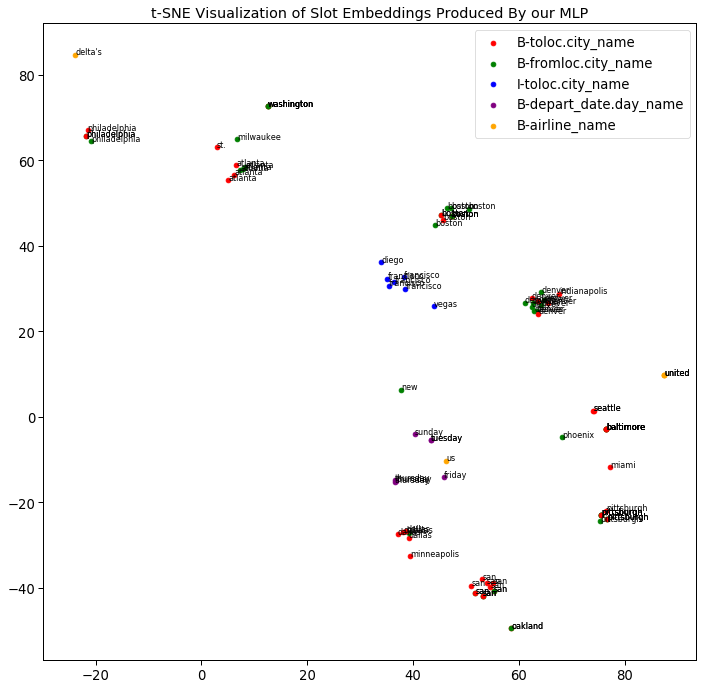

In [434]:
# color for map
#https://stackoverflow.com/questions/48512690/matplotlib-change-marker-color-based-on-label-value
slot_legend = {'B-toloc.city_name':'red',
                 'B-fromloc.city_name':'green',
                 'I-toloc.city_name':'blue',
                 'B-depart_date.day_name':'purple',
                 'B-airline_name':'orange'}
col2slot = {'red':'B-toloc.city_name',
            'green':'B-fromloc.city_name',
            'blue':'I-toloc.city_name',
            'purple':'B-depart_date.day_name',
            'orange': 'B-airline_name'}
color= [slot_legend[sampled_slot_embs['slot'][idx]] for idx in sampled_slot_embs.index]
fig, ax = plt.subplots(figsize=a4_dims)
for i in range(len(sampled_slot_embs)):
    plt.text(sampled_slot_embs['x'][i], sampled_slot_embs['y'][i], sampled_slot_embs['word'][i],
             fontdict={ 'size': 8})
    plt.scatter(x=sampled_slot_embs['x'][i],
                y=sampled_slot_embs['y'][i],
                c=color[i],
                label=col2slot[color[i]])
# https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend?noredirect=1&lq=1
from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title('t-SNE Visualization of Slot Embeddings Produced By our MLP')
fig = ax.get_figure()
fig.savefig("graphs/tsne_slot.png",bbox_inches="tight",dpi=300)

# ================

# t-SNE visualization of average embeddings used to predict intent

In [415]:
# intent data
indicies_to_skip = set()#-1
idx = 0
intent_embedding_data = {'intent':[],'x':[],'y':[]}
for i in range(len(data_used_eval['intents'])):
    for j in range(len(data_used_eval['intents'][i])):
        #print(data_used_eval['intents'][i][j])
        intent_encode = data_used_eval['intents'][i][j].item()
        if intent_encode != -1:
            word_as_str = index2intent[intent_encode]
            intent_embedding_data['intent'].append(word_as_str)
        else:
            indicies_to_skip.add(idx)
        idx+=1
        
idx

500

In [394]:
#indicies_to_skip
data_used_eval['avg_embeddings'][1].size()

torch.Size([10, 256])

In [416]:
#get embeddings and stack them so we can do tsne
all_avg_emb = []
avg_idx = 0
for batch_emb in data_used_eval['avg_embeddings']:
    #flatten
    #flattened_batch_emb = batch_emb.view(-1,embed_size).cpu().detach().numpy()
    for avg_emb in batch_emb:
        if avg_idx not in indicies_to_skip:
            all_avg_emb.append(avg_emb.cpu().detach().numpy())
        avg_idx+=1

all_avg_emb = np.asarray(all_avg_emb)

In [417]:
#all_avg_emb
all_avg_emb = tsne.fit_transform(all_avg_emb)

In [418]:
for point in all_avg_emb:
    intent_embedding_data['x'].append(point[0])
    intent_embedding_data['y'].append(point[1])

In [419]:
len(intent_embedding_data['y'])

499

In [420]:
intent_emb_df = pd.DataFrame(intent_embedding_data)
intent_emb_df.head()

,intent,x,y
0,atis_flight,2.160305,-1.064832
1,atis_airfare,17.710600,-0.122262
2,atis_aircraft,2.877719,-20.975836
3,atis_flight,-25.730066,-5.584008
4,atis_abbreviation,18.858675,13.141591


In [421]:
# droppling labels we don't want
wanted_labels = ['atis_flight',
                 'atis_airfare',
                 'atis_ground_service',
                 'atis_airline',
                 'atis_abbreviation']
focus_intent_emb_df = intent_emb_df[intent_emb_df['intent'].isin(wanted_labels)]

In [424]:
focus_intent_emb_df.head()

,intent,x,y
0,atis_flight,2.160305,-1.064832
1,atis_airfare,17.710600,-0.122262
3,atis_flight,-25.730066,-5.584008
4,atis_abbreviation,18.858675,13.141591
5,atis_abbreviation,20.409348,16.643488


In [456]:
sampled_intent_embs = focus_intent_emb_df.sample(n=400,random_state=423)
sampled_intent_embs.reset_index(inplace=True)

In [469]:
new_a4_dims = (a4_dims[0]*1.5,a4_dims[1]*1.5)
plt.rcParams.update({'font.size': 30})

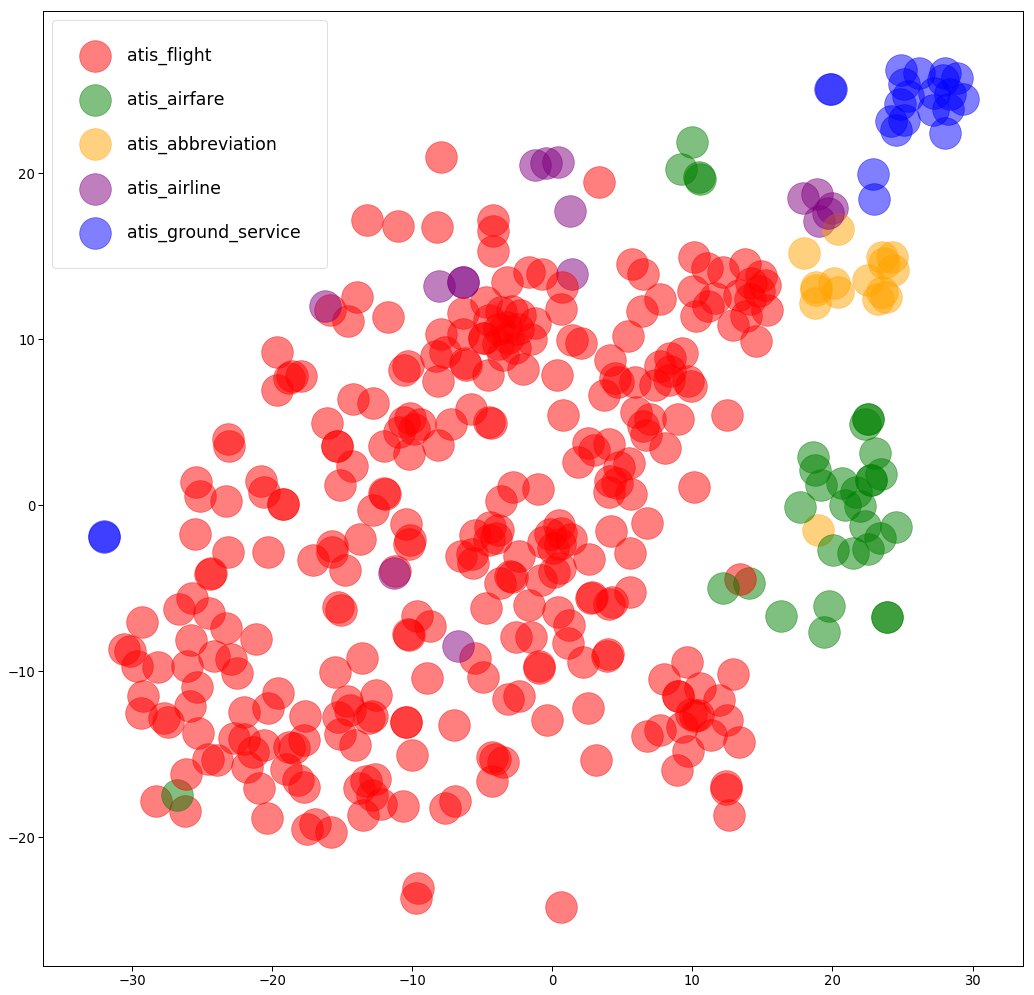

In [472]:
# color for map
#https://stackoverflow.com/questions/48512690/matplotlib-change-marker-color-based-on-label-value
intent_legend = {'atis_flight':'red',
                 'atis_airfare':'green',
                 'atis_ground_service':'blue',
                 'atis_airline':'purple',
                 'atis_abbreviation':'orange'}
col2intent = {'red':'atis_flight',
            'green':'atis_airfare',
            'blue':'atis_ground_service',
            'purple':'atis_airline',
            'orange': 'atis_abbreviation'}

color= [intent_legend[sampled_intent_embs['intent'][idx]] for idx in sampled_intent_embs.index]
size = [2.5*len(color)]
fig, ax = plt.subplots(figsize=new_a4_dims)
for i in range(len(sampled_intent_embs)):
#     plt.text(sampled_intent_embs['x'][i], sampled_intent_embs['y'][i], sampled_intent_embs['intent'][i],
#              fontdict={ 'size': 8})
    plt.scatter(x=sampled_intent_embs['x'][i],
                y=sampled_intent_embs['y'][i],
                c=color[i],
                label=col2intent[color[i]],
                   alpha=0.5,
               s=size)
# https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend?noredirect=1&lq=1
from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
#https://stackoverflow.com/questions/20048352/how-to-adjust-the-size-of-matplotlib-legend-box
plt.legend(by_label.values(), by_label.keys(),borderpad=1.5,labelspacing=1.5,fontsize= 'xx-small') 
#ax.grid(True)
#plt.title('t-SNE Visualization of Average Slot Embeddings used by our MLP in Intent Predictions')
fig = ax.get_figure()
fig.savefig("graphs/tsne_intent_slides.png",bbox_inches="tight",dpi=300)

# ============== #

In [316]:
len(slot_embedding_data['slot']),len(slot_embedding_data['word']),len(slot_embedding_data['embedding'])

KeyError: 'embedding'

In [271]:
slot_embedding_df = pd.DataFrame(slot_embedding_data)
slot_embedding_df['embedding'].head()

0    [-0.44389284, -1.52996, -0.8826251, 0.47196284...
1    [0.098725885, -2.7252479, 0.08809929, 1.240574...
2    [-1.3626413, 0.41064957, 0.20657355, 1.8658653...
3    [0.6087192, -0.16326652, -0.018569075, 0.78698...
4    [-0.14804126, 0.015542818, 0.038215805, -0.099...
Name: embedding, dtype: object

In [281]:
slot_embedding_data = {'embeddings':[], 'intents':[]}

In [282]:
# add each embedding:
for i in slot_embedding:
    slot_embedding_data['embeddings'].append(i)

# Convert each intent from tensor to int
for i in true_intents:
    slot_embedding_data['intents'].append(i.item())
print(len(slot_embedding_data['embeddings']))

10


In [283]:
pad_as_vector = slot_embedding[0][-1].cpu().detach().numpy()# will always be a pad
#pad_as_vector#.shape

In [284]:
# reshaping each embedding
for i in range(len(slot_embedding_data['embeddings'])):
    slot_embedding_data['embeddings'][i] = slot_embedding_data['embeddings'][i].reshape(-1,embed_size).cpu().detach().numpy()
print(len(slot_embedding_data['embeddings']))
#reshaped_slot_embed = slot_embedding.reshape(-1,embed_size).cpu().detach().numpy()
#reshaped_slot_embed[0]

10


In [285]:
#https://stackoverflow.com/questions/26154711/filter-rows-of-a-numpy-array/26154854
def remove_zero_embed(row,zero_embed):
    return row != zero_embed
#bool_arr = np.array([remove_zero_embed(row,pad_as_vector) for row in reshaped_slot_embed])

In [286]:
#removing pad embeddings from reshaped embeddings:
for i in range(len(slot_embedding_data['embeddings'])):
    bool_arr = np.array([remove_zero_embed(row,pad_as_vector) for row in slot_embedding_data['embeddings'][i]])
    #getting rid of zero embed
    slot_embedding_data['embeddings'][i] = slot_embedding_data['embeddings'][i][bool_arr].reshape(-1,embed_size)
    

In [287]:
#reshaped_slot_wo_zero = reshaped_slot_embed[bool_arr].reshape(-1,embed_size)

In [288]:
#reshaped_slot_wo_zero.shape
for i in range(len(slot_embedding_data['embeddings'])):
    print(slot_embedding_data['embeddings'][i].shape)

(12, 256)
(12, 256)
(22, 256)
(11, 256)
(15, 256)
(14, 256)
(5, 256)
(8, 256)
(4, 256)
(25, 256)


In [289]:
#https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py
print("Computing t-SNE embedding")
tsne = TSNE(n_components=2,init='pca',random_state=423)

Computing t-SNE embedding


In [291]:
# fitting T-SNE and transforming our embeddings
for i in range(len(slot_embedding_data['embeddings'])):
    print(slot_embedding_data['embeddings'][i].shape)
    slot_embedding_data['embeddings'][i] = tsne.fit_transform(slot_embedding_data['embeddings'][i])
#X_tsne = tsne.fit_transform(reshaped_slot_wo_zero)

(12, 2)
(12, 2)
(22, 2)
(11, 2)
(15, 2)
(14, 2)
(5, 2)
(8, 2)
(4, 2)
(25, 2)


In [167]:
len(slot_embedding_data['embeddings']),len(slot_embedding_data['intents'])

(10, 10)

In [171]:
slot_embedding_df = pd.DataFrame(slot_embedding_data)
slot_embedding_df

,embeddings,intents
0,"[[-10.80804, 344.3025], [-139.90424, 104.38813...",11
1,"[[369.7609, -211.07243], [-150.80087, 267.6449...",11
2,"[[-37.991627, 11.897672], [-39.449768, 126.641...",11
3,"[[-72.04335, -263.56552], [102.5343, -12.18836...",3
4,"[[-63.747513, 148.6373], [149.99443, -136.1053...",11
5,"[[293.53067, 556.27997], [-47.164776, 690.1631...",11
6,"[[138.18396, -736.0537], [-238.73946, -150.476...",11
7,"[[-280.37274, -141.47742], [-169.09671, 71.370...",11
8,"[[-40.179573, 77.2057], [61.02913, 138.7815], ...",4
9,"[[-127.38619, -214.39937], [-252.8628, -589.63...",11


# Just create a massive dataframe 

In [188]:
#labels
reshaped_labels = labels.reshape(-1).detach().numpy()
reshaped_labels_wo_zero = reshaped_labels[reshaped_labels>0]
reshaped_labels_wo_zero.shape

(127,)

In [211]:
tsne_labels = []
for i in range(len(reshaped_labels_wo_zero)):
    tsne_labels.append(index2tag[reshaped_labels_wo_zero[i]])
    #reshaped_labels_wo_zero[i] = index2tag[reshaped_labels_wo_zero[i]]
len(tsne_labels)

127

In [215]:
mass_slot_emb = {'x':[], 'y':[],'intent':[],'slot':[]}
count = 0
for i in range(len(slot_embedding_data['embeddings'])):
    for point in slot_embedding_data['embeddings'][i]:
        mass_slot_emb['x'].append(point[0])
        mass_slot_emb['y'].append(point[1])
        mass_slot_emb['intent'].append(slot_embedding_data['intents'][i])
        mass_slot_emb['slot'].append(tsne_labels[count])
        count+=1
len(mass_slot_emb['slot'])

127

In [217]:
mass_slot_emb_df = pd.DataFrame(mass_slot_emb)
mass_slot_emb_df.head()

,x,y,intent,slot
0,-10.808040,344.302490,11,O
1,-139.904236,104.388130,11,O
2,-261.577393,-165.728378,11,O
3,-22.561872,-90.621140,11,O
4,198.197800,-198.362686,11,B-depart_date.day_name


In [218]:
# droppling labels we don't want
unwanted_labels = ['O','<SOS>','<EOS>','<UNK>']
mass_slot_emb_df = mass_slot_emb_df[~mass_slot_emb_df['slot'].isin(unwanted_labels)]

In [226]:
for i in mass_slot_emb_df.index

Int64Index([  4,   5,   7,   9,  13,  17,  21,  22,  23,  25,  28,  30,  32,
             39,  41,  43,  44,  45,  52,  54,  61,  63,  65,  66,  67,  70,
             71,  76,  80,  81,  83,  84,  85,  96,  97,  99, 100, 101, 103,
            105, 110, 119, 120, 121, 123, 125],
           dtype='int64')

In [ ]:
#print(X_tsne[:,0])
fig, ax = plt.subplots(figsize=a4_dims)
for i in range(X_tsne.shape[0]):
#     dist = np.sum((X_tsne[i] - shown_images) ** 2, 1)
#             if np.min(dist) < 4e-3:
#                 # don't show points that are too close
#                 continue
    plt.text(X_tsne[i, 0], X_tsne[i, 1], str(reshaped_labels_wo_zero[i]),
             color=plt.cm.Set1(reshaped_labels_wo_zero[i] / 100.),
             fontdict={'weight': 'bold', 'size': 9})
plt.scatter(X_tsne[:,0],X_tsne[:,1])
plt.title('t-SNE visualization of test data')
fig = ax.get_figure()
#fig.savefig("tsne",dpi=300)
#plt.show()

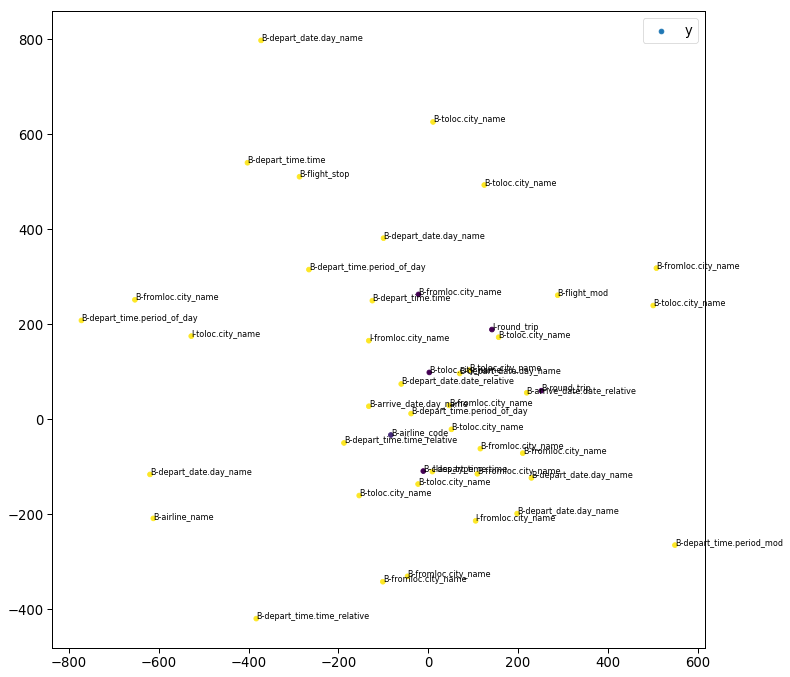

In [239]:
fig, ax = plt.subplots(figsize=a4_dims)
for i in mass_slot_emb_df.index:
    plt.text(mass_slot_emb_df['x'][i], mass_slot_emb_df['y'][i], mass_slot_emb_df['slot'][i],
             fontdict={ 'size': 8})

plt.scatter(data=mass_slot_emb_df,x='x',y='y',c='intent')
plt.legend()

array([11,  3,  4])